# Fairness in AI: Removing word embeddings

#### Kylian van Geijtenbeek, Thom Visser, Martine Toering, Iulia Ionescu

In this paper we reproduce the word embedding debiasing algo-rithm from Bolukbasi et al. [2]. We adapt their online codebase and extend it with their soft debiasing method, integrate several popular benchmarks and investigate the effectiveness of the algorithmon the newer fastText, BERT and XLNet embeddings, besides the Word2vec embeddings used by Bolukbasi et al. [2]. We show that the removal of direct bias from all the different embeddings barely affects their effectiveness through a comparison of benchmark scores. However, we fail to reproduce the large scale soft debiasing results due to a lack of detail on the original implementation.

In [1]:
from __future__ import print_function, division
%matplotlib inline
from matplotlib import pyplot as plt
import json
import random
import numpy as np

import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding
from debiaswe.data import load_professions

## Notebook preferences

# 1 - Gender Bias in word2vec, Glove and FastText

### Load data
Word embedding word2vec is trained on a corpus of Google News texts consisting of 3 million English words. The embedding maps each word into a 300-dimension vector. Glove web-crawl. FastText is a word embedding from Facebook AI Research lab trained on Wikipedia.

In [2]:
w2v = './embeddings/w2v_gnews_small.txt'
glove = './embeddings/glove-300d_small.txt'
ft = './embeddings/fasttext_wiki-news-300d_small.txt'

In [3]:
# TODO 

# Load google news word2vec
E = WordEmbedding(w2v)

# Load Glove
E_g = WordEmbedding(glove)

# Load FastText 
E_ft = WordEmbedding(ft)

*** Reading data from ./embeddings/w2v_gnews_small.txt
(26423, 300)
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
*** Reading data from ./embeddings/glove-300d_small.txt
(42982, 300)
42982 words of dimension 300 : the, and, to, of, ..., cushman, darkside, motherland, chairmen
*** Reading data from ./embeddings/fasttext_wiki-news-300d_small.txt
(27014, 300)
27014 words of dimension 300 : the, and, of, to, ..., circumscribed, whos, salvaging, anion


In [4]:
# Load professions from Bolukbasi et al.
professions = load_professions()
profession_words = [p[0] for p in professions]

Loaded professions
Format:
word,
definitional female -1.0 -> definitional male 1.0
stereotypical female -1.0 -> stereotypical male 1.0


In [5]:
# Plot manifolds
# print(np.linalg.norm(E.vecs, axis=1).mean())
# print(E.vecs.mean())

# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2).fit_transform(E.vecs[:2000])
# plt.scatter(tsne[:,0], tsne[:,1], s=10)
# plt.show()

### Define gender direction

In [6]:
# Define gender direction with the words "she" and "he" 
# v_gender = E.diff('she', 'he')

# Define gender direction with PCA
with open('./data/definitional_pairs.json', "r") as f:
    defs = json.load(f)
v_gender = we.doPCA(defs, E).components_[0]

### Generating analogies


In [7]:
# Analogies gender
# a_gender = E.best_analogies_dist_thresh(v_gender, thresh=1)

# Visualising
# we.viz(a_gender)

### Analyzing occupational gender bias 


In [8]:
# Analysis of extreme male and extreme female professions
sp = E.profession_stereotypes(profession_words, v_gender)

                Female                |                 Male                 
-----------------------------------------------------------------------------
0.38                    businesswoman | maestro                        -0.244
0.379                         actress | protege                        -0.236
0.378                       housewife | statesman                      -0.222
0.323                       homemaker | businessman                    -0.219
0.308                           nurse | sportsman                      -0.209
0.302                registered_nurse | philosopher                    -0.196
0.297                        waitress | marksman                       -0.192
0.28                     receptionist | skipper                        -0.187
0.278                       socialite | financier                      -0.183
0.277                       librarian | architect                      -0.177
0.272                            maid | magician                

# 2 - Comparing Bias of word2vec, Glove and FastText

In [17]:
# Change this to either fastText or Glove to compare word2vec (E) word embedding to a second word embedding
E_compare = E_g

In [18]:
def get_datapoints(sp, E, v_gender, words_set):
    sp = sorted([(E.v(w).dot(v_gender), w) for w in profession_words if w in words_set])
    points = [s[0] for s in sp]
    words = [s[1] for s in sp]
    words_sorted_ind = sorted(range(len(words)), key=lambda k: words[k])
    datapoints =  [points[i] for i in words_sorted_ind]
    return datapoints

In [19]:
# Define gender direction and analyse occupational bias in other word embedding
v_gender_compare = E_compare.diff('she', 'he')
sp_compare = E_compare.profession_stereotypes(profession_words, v_gender_compare)

words_set = [s[1] for s in sp_compare]
compare_datapoints = get_datapoints(sp_compare, E_compare, v_gender_compare, words_set)
og_datapoints = get_datapoints(sp, E, v_gender, words_set)

                Female                |                 Male                 
-----------------------------------------------------------------------------
0.319                         actress | infielder                      -0.198
0.308                       ballerina | statesman                      -0.192
0.253                       housewife | archbishop                     -0.188
0.246                           nurse | philosopher                    -0.185
0.225                         stylist | commander                      -0.183
0.225                       socialite | baron                          -0.181
0.197                            maid | colonel                        -0.179
0.196                   businesswoman | priest                         -0.173
0.189                       homemaker | inventor                       -0.173
0.188                        waitress | sportsman                       -0.17
0.173                       librarian | preacher                

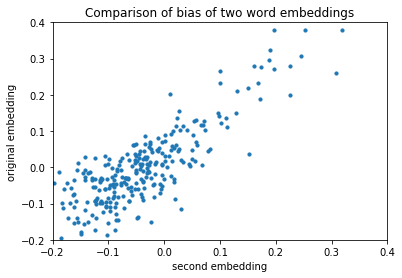

In [23]:
# Plot comparison of bias of word2vec and fastText
fig, ax = plt.subplots()
ax.set_ylim(-0.2, 0.4)
ax.set_xlim(-0.2, 0.4)
plt.title("Comparison of bias of two word embeddings")
plt.xlabel("second embedding")
plt.ylabel("original embedding")
plt.scatter(compare_datapoints, og_datapoints, s=10)

# 3 - Debiasing algorithms on word2vec, Glove and FastText

## Hard debiasing

In hard debiasing, the gender neutral words are shifted to zero in the gender subspace (i.e. neutralized) by subtracting the projection of the neutral word embedding vector onto the gender subspace and renormalizing the resulting embedding to unit length. 

## Soft debiasing

We adapted specifics from Manzini et al., Soft debiasing is done by solving the following optimization problem as mentioned in their paper:

\begin{equation}
    \underset{T}{\min} || (TW)^T(TW) - W^TW||^2_F + \lambda ||(TN)^T (TB)||^2_F
\end{equation}

where W is the matrix of all embedding vectors, N is the matrix of the embedding vectors of the gender neutral words, B is the gender subspace, and T is the debiasing transformation that minimizes the projection of the neutral words onto the gender subspace but tries to maintain the pairwise inner products between the words

In [ ]:
from debiaswe.debias import hard_debias

In [ ]:
# Load gender related word lists from Bolukbasi et al.
with open('./data/definitional_pairs.json', "r") as f:
    defs = json.load(f)

with open('./data/equalize_pairs.json', "r") as f:
    equalize_pairs = json.load(f)

with open('./data/gender_specific_seed.json', "r") as f:
    gender_specific_words = json.load(f)

In [ ]:
# Hard debias
hard_debias(E, gender_specific_words, defs, equalize_pairs)

# Soft debias
# soft_debias(E, gender_specific_words, defs)

In [ ]:
# Save hard debiased embeddings
E.save('./embeddings/w2v_gnews_small_hard_debiased.txt')

In [ ]:
# Analysis of extreme male and extreme female professions
sp_debiased = E.profession_stereotypes(profession_words, v_gender)

In [ ]:
# Analogies gender
a_gender_debiased = E.best_analogies_dist_thresh(v_gender)

# Visualising
we.viz(a_gender_debiased)

# 4 - Benchmarks